In [26]:
import glob
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import cv2
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [12]:
model = torch.load("/content/drive/MyDrive/savemodels/bestmodel_epoch_27_score_94.77.pt")

In [10]:
val_transforms = A.Compose(
        [
            A.Resize(height=512, width=512),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

class SegDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        image = cv2.imread(img_path)
        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]
        return image, img_path



In [48]:
test_imgs = glob.glob("/content/drive/MyDrive/SegmenData2/test/*.jpg")

test_ds = SegDataset(
        image_dir=test_imgs,
        transform=val_transforms,
    )
Test_loader = DataLoader(
        test_ds,
        batch_size=1,
        pin_memory=True,
        shuffle=True,
    )

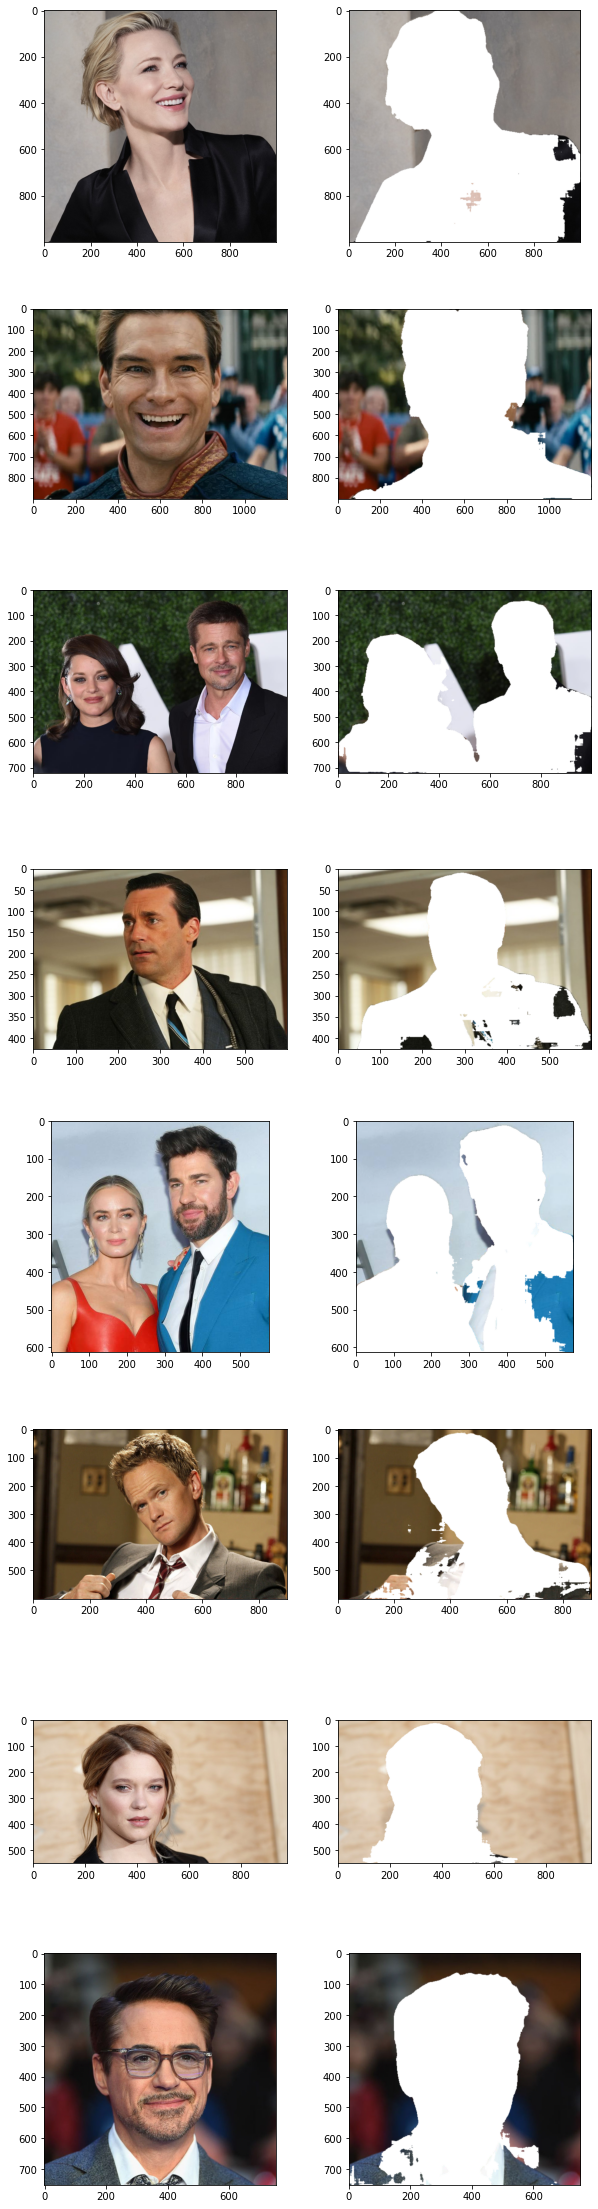

In [62]:
ax = []
fig = plt.figure(figsize=(10, 40))

for i ,(x , img_path) in enumerate(Test_loader):
  x = x.to("cuda")
  prediction = torch.sigmoid(model(x))
  prediction = (prediction > 0.5).float()
  prediction = prediction.squeeze().cpu().numpy()*255
  prediction = prediction.astype(np.uint8)
  prediction = np.expand_dims(prediction,-1)

  frame = cv2.imread(img_path[0])
  h,w,_ = frame.shape
  image = cv2.resize(frame,(512,512))
  outimg = np.where(prediction== 255, 255, image)
  outimg = cv2.cvtColor(outimg,cv2.COLOR_BGR2RGB)
  frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  outimg = cv2.resize(outimg,(w,h))
  ax.append( fig.add_subplot(8, 2, 2*i+2))
  plt.imshow(outimg)
  ax.append( fig.add_subplot(8, 2, 2*i+1))
  plt.imshow(frame)